## MODEL: TRANSFER LEARNING USING VGG16 CONVOLUTIONAL NEURAL NETWORK 

Transfer learning is a technique in machine learning and deep learning where a pre-trained model is used as a starting point for a new related task. Instead of building a model from scratch and training it on a large dataset, transfer learning allows us to leverage the knowledge already gained by the pre-trained model. In transfer learning, you typically take the pre-trained model and replace the final layer with a new layer that is specific to the new task. This new layer is then trained on the smaller dataset specific to the new task, while the rest of the pre-trained model is frozen and its weights are fixed. This allows us to fine-tune the pre-trained model on the new task while avoiding overfitting and reducing training time.

In [1]:
# Importing required libraries
import os 
import pandas as pd 
import numpy as np 
import random 
import sys 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import cv2 as cv
import seaborn as sns 
import keras 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer  
from PIL import Image  
from IPython.display import SVG  
from keras import layers, metrics, optimizers, models, preprocessing 
from keras.models import load_model, Sequential  
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D  
from keras.preprocessing import image 
from keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay





Load the labelled dataset

In [2]:
#loading the dataset composed of the images previously labelled and creating two lists:
#one for the subdirectories name and one for the corresponding entry counts
#setting the directory of the labelled images
label_dir = "C:/Users/Utente/Desktop/Project_ML_Reply/Immagini_labels/LABELLED_IMAGES"

#we use the os module to list the subdirectories
classes = os.listdir(label_dir)  # Get the list of subdirectories name in the specified labels_dir
#creating a list that stores he number of files in each subdirectory
count_label_imgs = [len(os.listdir(os.path.join(label_dir, cls))) for cls in classes]  # Count files in each subdirectory

# Print the classes and the number of files in each subdirectory
print(classes)
print(count_label_imgs)

['Advertisements', 'E-mail', 'Handwritten Documents', 'Other', 'Resumé']
[376, 353, 523, 283, 907]


Analysing the distribution of classes

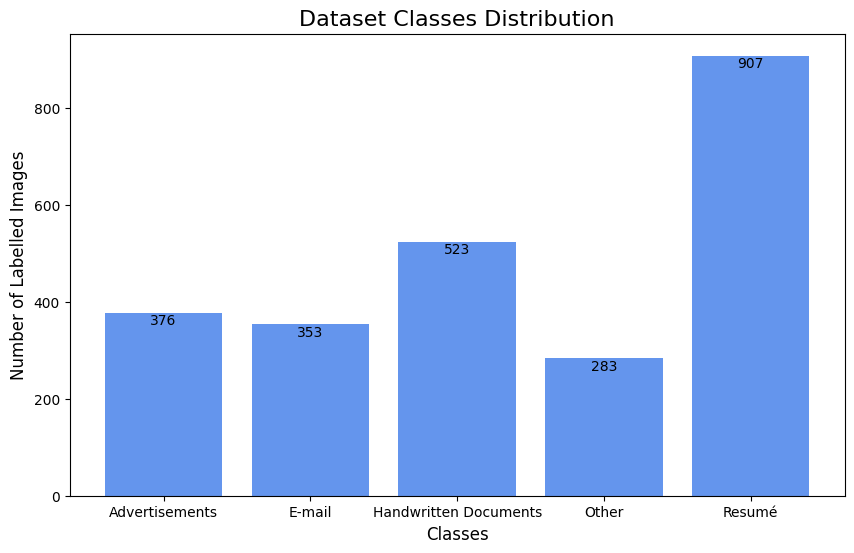

In [3]:
#plotting the class distribution with class names on the x-axis and the number of labelled images on the y-axis and annotations showing the exact count for each bar
plt.figure(figsize=(10, 6))
plt.bar(classes, count_label_imgs, color='cornflowerblue')

# Setting title and labels
plt.title('Dataset Classes Distribution', fontsize=16)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Labelled Images', fontsize=12)

# Adding values on top of each bar.Annotating each bar with its height
for i, value in enumerate(count_label_imgs):
    plt.text(i, value - 30, str(value), ha='center', va='bottom')

plt.show()

There is a number of 5 classes in the dataset and from the graph we can notice class imbalance since there are different numbers of entries for each class. This is a multi-class classification problem.


# Inizializing variables for model building 

Inizialising various parameters for the implemented machine learning model used for image classification task is a necessary step that ensures the configuration and behaviour of the model itself. Moreover, adjusting them can have a significant impact on the training process and the performance of the model.

In [4]:
#initializing  some parameters
new_img_size = (224, 224)
batch_size = 32
train_size = 0.7
val_size = 0.2
seed = 42
test_size = 0.1
channels = 3


Let's describe them more in detail: 
1) ‘img_size’: Specifies the size (both width and height) to which input images should be resized before being fed into the machine learning model. In this case, images are resized to 224x224 pixels compatible with the VGG16.
2) ‘batch_size’: Defines the number of samples that will be propagated through the neural network in each training iteration. It helps optimize memory usage and computational efficiency.
3) ‘train_size’, ‘val_size’, and ‘test_size’: Determine the proportions of the dataset allocated for training, validation, and testing, respectively. In our case, 70% of the data is allocated for training, 20% for validation, and 10% for testing.
4) ‘channels’: Specifies the number of color channels in the images. In our case, notwithstanding our images are in greyscale and the associated channel should be 1, we use 3 that stands for RGB color images beacuse it's the format required by the VGG!& network.

In [5]:
#creating a list that stores the path of the images in a unique list in all the subdirectories in the specified labels_dir
#and another list for the corresponding class name

# create an empty list that will store the full path of the images
total_imgs = []
# create an empty list that will store the names of the subdirectories
total_labels = []

# walk through the specified directory containing the labelled images and get the path of each image
for root, dirs, files in os.walk(label_dir): #root is the main directory, dirs corresponds to the subdirectories and files are the images in each subdirectory
    for file in files:
        if file.endswith(".tif"):
            path = os.path.join(root, file)
            total_imgs.append(path)
            total_labels.append(root.split(os.path.sep)[-1])
            

#defining a function that takes an image file path as input, splits the path to extract the class label directory, and returns the class label.          
def class_label(img):
    return img.split(os.path.sep)[-2] #the index accesses the second last element of the path that refers to the class label 


print(total_imgs[0])
print('Class: ', class_label(total_imgs[0]))
print('Label : ', total_labels[0])

C:/Users/Utente/Desktop/Project_ML_Reply/Immagini_labels/LABELLED_IMAGES\Advertisements\0000106842.tif
Class:  Advertisements
Label :  Advertisements


# Splitting the dataset into training, test, and validation sets

We then split the dataset into training, validation, and test sets along with their corresponding labels. The data is divided based on the specified proportions set at the beginning.

In [6]:
#first of all we set the random seed and the shuffle to ensure that the images are randomly splitted in the three sets 
random.Random(seed).shuffle(total_imgs)
# Get data and separate it in sets
# we start by creating a variable that contains the total number of images in 'total_imgs'
total_len = len(total_imgs)
#we initialized to zero to keep track of the position in the list while iterating over the datset
index = 0

# Create the empty lists for the train, validation, and test sets as done for the total number of images in the previous cell
train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []

# iterating over the list containing the total number of images
for i in total_imgs[0: int(total_len*train_size)] : #iterates over a slice of the total_imgs list, strarting from index 0 to the index corresponding to the training set size
    train_set.append(i)
    train_label.append(class_label(i))
    
#updating the index after the first loop at the first index after the end of the training set
index = int(total_len*train_size)

#repeting the same process for the other two sets: the validation and the test sets 
for i in total_imgs[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(class_label(i))

#updating the index again
index = int(index + total_len*val_size)

#repeat for the final set that is the test set 
for i in total_imgs[index: total_len] :
    test_set.append(i)
    test_label.append(class_label(i))

#print a random sample from the val set with the corresponding label
print(val_set[300])
print(val_label[300])

C:/Users/Utente/Desktop/Project_ML_Reply/Immagini_labels/LABELLED_IMAGES\Resumé\50511027-1028.tif
Resumé


In [7]:
#check the shape of three created set and ensuring that the number of total images is the same of the original directory
print(len(val_set))
print(len(train_set))
print(len(test_set))


488
1709
245


# Preprocessing images

In order to feed the images in the VGG16 network, we have to pre-process them in order to adjust the size and channels of our images. Indeed, we define a function called ‘process_images’ that takes a set of image paths, reads and resizes each image, and returns the processed images. It is then used to process three different sets of images: ‘train_set’, ‘test_set’, and ‘val_set’, storing the results in ‘data_train’, ‘data_test’, and ‘data_val’ respectively.

In [9]:
# Define the new size for the images, both width and height, as already outlined at the beginning of the notebook
new_img_size = (224, 224) 


#Define a function that processes the images
def process_images(img_set, new_img_size):
    processed_images = [] #create an empty list to store the processed images 
    for path in img_set: #iterate over the set containing the full path of the images
        if os.path.exists(path): #checking if the path exists
            with Image.open(path) as img: #if it exists open the image and convert it to RGB and to the new size 
                processed_images.append(img.resize(new_img_size).convert('RGB'))
        
    return processed_images


In [10]:
# Process the images and store them in a new list that will be used to train the model
data_test = process_images(test_set, new_img_size)
data_train = process_images(train_set, new_img_size)
data_val = process_images(val_set, new_img_size)


# converting classes into binary labels 

We use the ‘LabelBinarizer’ to convert a list of classes into binary labels, and then transforms the training, testing, and validation labels accordingly. It also converts the processed images into numpy arrays and assigns them to corresponding variables. More precisely, each class label is represented by a binary vector where only one element is 1 (indicating the presence of the class) and all other elements are 0. This pre-process step is largely employed in image classification tasks insofar as it simplifies the handling of categorical labels, making it easier to train and evaluate machine learning models effectively. 

In [11]:
lb = LabelBinarizer() #inizialize the label binarizer to convert categorical labels to binary vectors
lb.fit(list(classes)) #Fit the label binarizer to the list of classes to assign a unique binary vector to each class label

#we convert the training dataset, the validation dataset and the test dataset into numpy arrays
#then transform the labels using the label binarizer into binary vectors according to the number of classes
x_train = np.array(data_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(data_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(data_val)
y_val = lb.transform(np.array(val_label))

In [12]:
#viewing the shape of the data for train validation and test
print("train images shape : ", x_train.shape)
print("train labels shape : ", y_train.shape)

print("valdiation shape : ", x_val.shape)
print(y_val.shape)

print("test shape : ", x_test.shape)
print(y_test.shape)


train images shape :  (1709, 224, 224, 3)
train labels shape :  (1709, 5)
valdiation shape :  (488, 224, 224, 3)
(488, 5)
test shape :  (245, 224, 224, 3)
(245, 5)


as we can note, there are 1709 colored images with shape equal (224, 224) for the training, 488 colored images with shape equal (224, 224) for the validation and 245 colored images with shape equal (224, 224) for the test set. 

In [13]:
# print the first image and its corresponding label of the train set to compare the label from 
#the original dataset and the one obtained from the label binarizer to ensure that the label binarizer worked as expected
print(train_label[0])
print(y_train[0])
print(lb.classes_)

Advertisements
[1 0 0 0 0]
['Advertisements' 'E-mail' 'Handwritten Documents' 'Other' 'Resumé']


## Model building


In order to build the model used for document classification task, we import the pre-trained VGG16 model with ImageNet weights, excluding the top classification layer. We then specify the shape of the input images according to the criterion we defined during the preprocessing and then print the summary of the VGG16 model architecture.

The VGG16 model is a popular image classification model that won the ImageNet competition in 2014. It has 16 layers, including 13 convolutional layers and 3 fully connected layers. It is trained on a large dataset of images and can recognize a wide range of features.





In [14]:
#define the base model 
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
# we then mark the base model as not trainable to freeze the weights
base_model.trainable = False
#printing the summary of the model
base_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Pre-trained on the ImageNet dataset, VGG16 leverages transfer learning by transferring its learned weights to new tasks, making it a versatile and widely used model in various task.

# customize our model

We then define a neural network model by extending the VGG16 base model. First add a flattening layer to convert the output of the convolutional base into a one-dimensional array, followed by a dense layer with 128 units and ReLU activation. A dropout layer with a dropout rate of 0.5 is incorporated to mitigate overfitting, and the final dense layer produces class predictions using a softmax activation function, tailored to the specific number of classes in the dataset.

In [15]:
#creating a customized model to extend the VGG16 base model.
model = models.Sequential()
#adding the base model
model.add(base_model)
#adding the new layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu',  name='dense'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

# build the model by specifying the input shape
model.build(input_shape=(None, 224, 224, 3))  # The 'None' allows the model to handle variable batch sizes
# printing the summary of the model
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,725 (68.39 MB)

 Trainable params: 3,212,037 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# model compilation and training 

The neural network model is compiled using the Adam optimizer with a specified learning rate, categorical cross-entropy loss function, and accuracy as the evaluation metric. The model is then trained on the training data (‘x_train’ and ‘y_train’) for a specified number of epochs and batch size. The validation data is provided for monitoring performance during training. 
There are no hard and fast rules for choosing an optimizer or a loss function for training CNN models, as the best choice depends on the specific problem and the characteristics of the data. It is often a good practice to experiment with different optimizers and learning rates, as well as different loss functions, to find the combination that works best for a given problem. In our case, for multi-class classification problems, the categorical cross-entropy loss function is commonly used and often gives a good performance. This loss function measures the difference between the predicted class probabilities and the true class labels for each input, and encourages the model to output high probabilities for the correct class and low probabilities for the incorrect classes.

In [16]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=20,
                        verbose=1,
                        validation_data=(x_val, y_val))

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 456s 8s/step - accuracy: 0.3239 - loss: 11.1200 - val_accuracy: 0.5717 - val_loss: 2.9123
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 419s 8s/step - accuracy: 0.5341 - loss: 4.9220 - val_accuracy: 0.7234 - val_loss: 1.8288
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 442s 8s/step - accuracy: 0.6803 - loss: 2.8907 - val_accuracy: 0.7664 - val_loss: 1.4417
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 397s 7s/step - accuracy: 0.7414 - loss: 1.9294 - val_accuracy: 0.7910 - val_loss: 1.2690
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.7347 - loss: 1.7034 - val_accuracy: 0.8033 - val_loss: 1.1483
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.7684 - loss: 1.2898 - val_accuracy: 0.8176 - val_loss: 1.0085
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 465s 8s/step - accuracy: 0.7993 - loss: 1.0175 - val_accuracy: 0.8361 - val_loss: 0.9924
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 502s 9s/step - accuracy: 0.8391 - loss: 0.7583 - val_accuracy: 0.8402 - 

# Visualising performances 

this step is done to assess the training process and to identify potential overfitting or underfitting issues

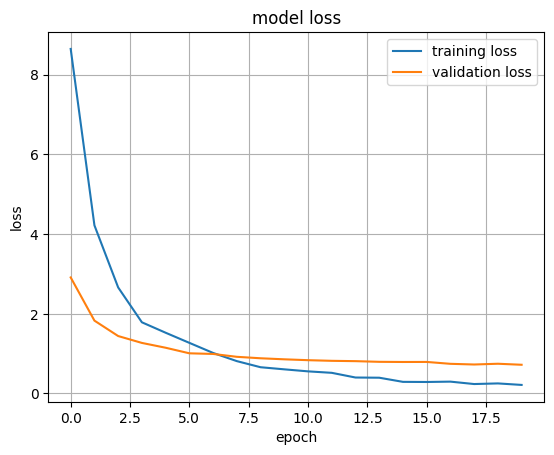

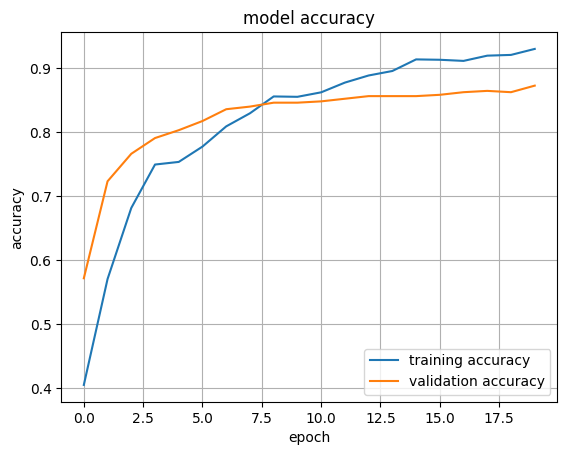

In [17]:
# we create two different plots for training and validation loss over epochs, providing insights into how well the model is learning from data
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

#the second plot is for training and validation accuracy trends offering a view of the model's overall performance in terms of correctly classified istances
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.show()

In [18]:
#saving the model for later use
keras.saving.save_model(model, 'my_model.keras')

In [19]:
#evaluating test scores on the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.8911 - loss: 0.5153
Test loss: 0.4781642258167267
Test accuracy: 0.8938775658607483


We now assess the performance of the trained model on the test dataset by making predictions using the ‘predict’ method. The predictions are then compared to the actual labels and the count of correct and incorrect predictions is recorded.

In [20]:
predictions = model.predict(x_test, verbose=1)
predicted_classes = lb.classes_

count_true = 0
count_false = 0

# Initialize lists to collect true and predicted labels
true_labels = []
predicted_labels = []

for i, prediction in enumerate(predictions):
    prediction_index = np.argmax(prediction)  # Get the index of the maximum value
    predicted_label = predicted_classes[prediction_index]
    true_label = test_label[i]

    # Append the true and predicted labels to the respective lists
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

    # Check if the predicted label is the same as the true label
    if predicted_classes[prediction_index] == test_label[i]:
        count_true += 1
        state = True
    else:
        count_false += 1
        state = False
    print("Prediction:", predicted_classes[prediction_index], "| Real class:", test_label[i], "| Result:", state)

print("\nNumber of success:", count_true)
print("Number of errors:", count_false)
print("Error rate:", count_false / len(test_label))

8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step
Prediction: Advertisements | Real class: Advertisements | Result: True
Prediction: Resumé | Real class: Resumé | Result: True
Prediction: E-mail | Real class: E-mail | Result: True
Prediction: Other | Real class: Advertisements | Result: False
Prediction: Resumé | Real class: Resumé | Result: True
Prediction: Other | Real class: Handwritten Documents | Result: False
Prediction: Resumé | Real class: Resumé | Result: True
Prediction: Resumé | Real class: Resumé | Result: True
Prediction: Resumé | Real class: Resumé | Result: True
Prediction: E-mail | Real class: E-mail | Result: True
Prediction: Handwritten Documents | Real class: Handwritten Documents | Result: True
Prediction: E-mail | Real class: E-mail | Result: True
Prediction: Handwritten Documents | Real class: Advertisements | Result: False
Prediction: Advertisements | Real class: Advertisements | Result: True
Prediction: E-mail | Real class: E-mail | Result: True
Prediction: Resumé | Real cla

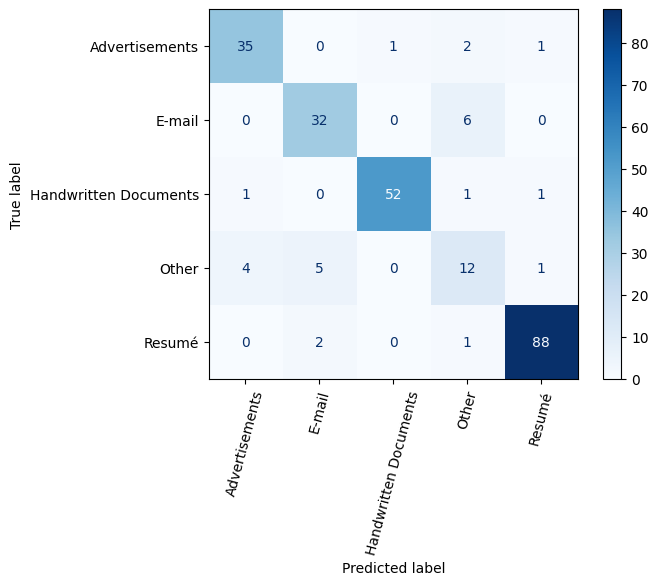

In [39]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=predicted_classes)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)

# Rotate the tick labels on the x-axis
plt.xticks(rotation=75)

# Show the plot
plt.show()

In [23]:
# plot the classification report
print(classification_report(true_labels, predicted_labels, labels=predicted_classes))

                       precision    recall  f1-score   support

       Advertisements       0.88      0.90      0.89        39
               E-mail       0.82      0.84      0.83        38
Handwritten Documents       0.98      0.95      0.96        55
                Other       0.55      0.55      0.55        22
               Resumé       0.97      0.97      0.97        91

             accuracy                           0.89       245
            macro avg       0.84      0.84      0.84       245
         weighted avg       0.89      0.89      0.89       245



Display the images from the test set along with their predicted and true classes. This visual representation aids in understanding the model’s performance at an individual image level, offering insights into specific instances where the model succeeded or failed in its predictions.

8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step


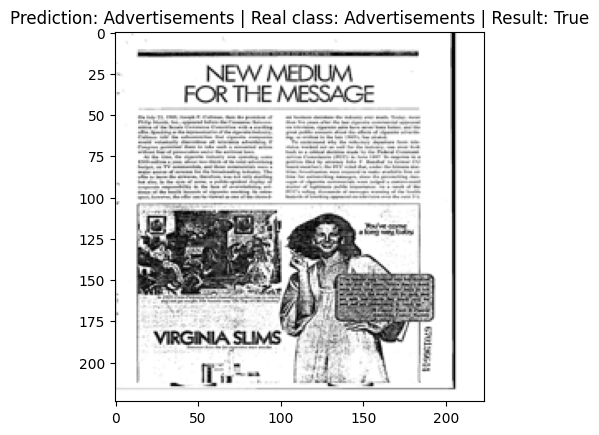

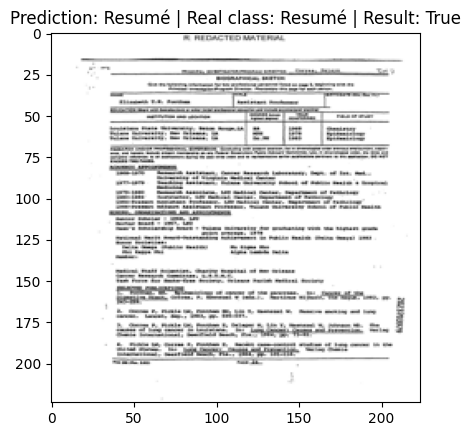

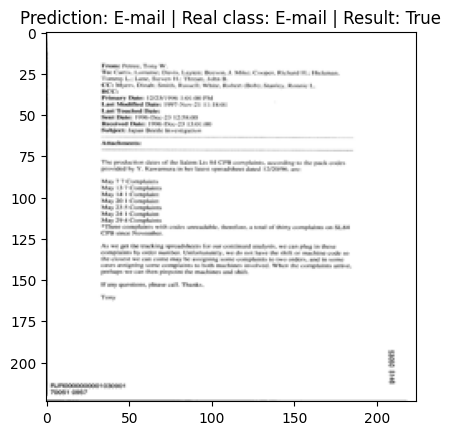

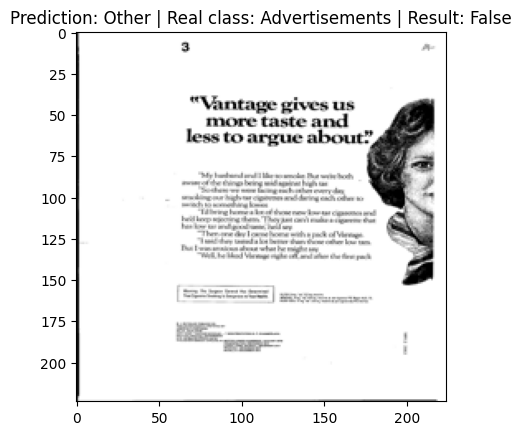

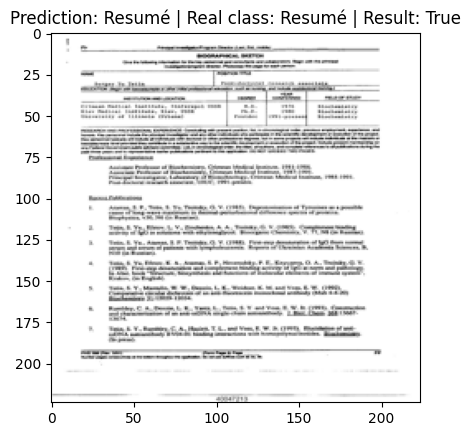

In [40]:
predictions = model.predict(x_test, verbose=1)
predicted_classes = lb.classes_

count_true = 0
count_false = 0

# A simple counter to track the number of images displayed
image_count = 0

for i, prediction in enumerate(predictions):
    if image_count >= 5:  # Break the loop after displaying 5 images
        break

    prediction_index = np.argmax(prediction)  # Get the index of the maximum value
    if predicted_classes[prediction_index] == test_label[i]:
        count_true += 1
        state = True
    else:
        count_false += 1
        state = False
    
    # Display the image
    plt.imshow(x_test[i])
    plt.title(f"Prediction: {predicted_classes[prediction_index]} | Real class: {test_label[i]} | Result: {state}")
    plt.show()

    image_count += 1  # Increment the counter after displaying each image
